# ASR Assignment 2022-23

This notebook has been provided as a template to get you started on the assignment.  Feel free to use it for your development, or do your development directly in Python.

You can find a full description of the assignment [here](http://www.inf.ed.ac.uk/teaching/courses/asr/2022-23/coursework.pdf).

You are provided with two Python modules `observation_model.py` and `wer.py`.  The first was described in [Lab 3](https://github.com/ZhaoZeyu1995/asr_labs/blob/master/asr_lab3_4.ipynb).  The second can be used to compute the number of substitution, deletion and insertion errors between ASR output and a reference text.

It can be used as follows:

```python
import wer

my_refence = 'A B C'
my_output = 'A C C D'

wer.compute_alignment_errors(my_reference, my_output)
```

This produces a tuple $(s,d,i)$ giving counts of substitution,
deletion and insertion errors respectively - in this example (1, 0, 1).  The function accepts either two strings, as in the example above, or two lists.  Matching is case sensitive.

## Template code

Assuming that you have already made a function to generate an WFST, `create_wfst()` and a decoder class, `MyViterbiDecoder`, you can perform recognition on all the audio files as follows:


In [1]:
import glob
import os
import wer
import observation_model
import math
import openfst_python as fst
def display_fst(f):
    from subprocess import check_call
    from IPython.display import Image
    f.draw('tmp.dot', portrait=True)
    check_call(['dot','-Tpng','-Gdpi=200','tmp.dot','-o','tmp.png'])
    return Image(filename='tmp.png')

def parse_lexicon(lex_file):
    """
    Parse the lexicon file and return it in dictionary form.
    
    Args:
        lex_file (str): filename of lexicon file with structure '<word> <phone1> <phone2>...'
                        eg. peppers p eh p er z

    Returns:
        lex (dict): dictionary mapping words to list of phones
    """
    
    lex = {}  # create a dictionary for the lexicon entries (this could be a problem with larger lexica)
    with open(lex_file, 'r') as f:
        for line in f:
            line = line.split()  # split at each space
            lex[line[0]] = line[1:]  # first field the word, the rest is the phones
    return lex

def generate_symbol_tables(lexicon, n=3):
    '''
    Return word, phone and state symbol tables based on the supplied lexicon
        
    Args:
        lexicon (dict): lexicon to use, created from the parse_lexicon() function
        n (int): number of states for each phone HMM
        
    Returns:
        word_table (fst.SymbolTable): table of words
        phone_table (fst.SymbolTable): table of phones
        state_table (fst.SymbolTable): table of HMM phone-state IDs
    '''
    
    state_table = fst.SymbolTable()
    phone_table = fst.SymbolTable()
    word_table = fst.SymbolTable()
    
    # add empty <eps> symbol to all tables
    state_table.add_symbol('<eps>')
    phone_table.add_symbol('<eps>')
    word_table.add_symbol('<eps>')
    
    for word, phones  in lexicon.items():
        
        word_table.add_symbol(word)
        
        for p in phones: # for each phone
            
            phone_table.add_symbol(p)
            for i in range(1,n+1): # for each state 1 to n
                state_table.add_symbol('{}_{}'.format(p, i))
            
    return word_table, phone_table, state_table


# call these two functions
lex = parse_lexicon('lexicon.txt')
word_table, phone_table, state_table = generate_symbol_tables(lex)

In [2]:

class MyViterbiDecoder:
    
    NLL_ZERO = 1e10  # define a constant representing -log(0).  This is really infinite, but approximate
                     # it here with a very large number
    
    def __init__(self, f, audio_file_name):
        """Set up the decoder class with an audio file and WFST f
        """
        self.om = observation_model.ObservationModel()
        self.f = f
        
        if audio_file_name:
            self.om.load_audio(audio_file_name)
        else:
            self.om.load_dummy_audio()
        
        self.initialise_decoding()

        
    def initialise_decoding(self):
        """set up the values for V_j(0) (as negative log-likelihoods)
        
        """
        
        self.V = []   # stores likelihood along best path reaching state j
        self.B = []   # stores identity of best previous state reaching state j
        self.W = []   # stores output labels sequence along arc reaching j - this removes need for 
                      # extra code to read the output sequence along the best path
        
        for t in range(self.om.observation_length()+1):
            self.V.append([self.NLL_ZERO]*self.f.num_states())
            self.B.append([-1]*self.f.num_states())
            self.W.append([[] for i in range(self.f.num_states())])  #  multiplying the empty list doesn't make multiple
        
        # The above code means that self.V[t][j] for t = 0, ... T gives the Viterbi cost
        # of state j, time t (in negative log-likelihood form)
        # Initialising the costs to NLL_ZERO effectively means zero probability    
        
        # give the WFST start state a probability of 1.0   (NLL = 0.0)
        self.V[0][self.f.start()] = 0.0
        
        # some WFSTs might have arcs with epsilon on the input (you might have already created 
        # examples of these in earlier labs) these correspond to non-emitting states, 
        # which means that we need to process them without stepping forward in time.  
        # Don't worry too much about this!  
        self.traverse_epsilon_arcs(0)        
        
    def traverse_epsilon_arcs(self, t):
        """Traverse arcs with <eps> on the input at time t
        
        These correspond to transitions that don't emit an observation
        
        We've implemented this function for you as it's slightly trickier than
        the normal case.  You might like to look at it to see what's going on, but
        don't worry if you can't fully follow it.
        
        """
        
        states_to_traverse = list(self.f.states()) # traverse all states
        while states_to_traverse:
            
            # Set i to the ID of the current state, the first 
            # item in the list (and remove it from the list)
            i = states_to_traverse.pop(0)   
        
            # don't bother traversing states which have zero probability
            if self.V[t][i] == self.NLL_ZERO:
                    continue
        
            for arc in self.f.arcs(i):
                
                if arc.ilabel == 0:     # if <eps> transition
                  
                    j = arc.nextstate   # ID of next state  
                
                    if self.V[t][j] > self.V[t][i] + float(arc.weight):
                        
                        # this means we've found a lower-cost path to
                        # state j at time t.  We might need to add it
                        # back to the processing queue.
                        self.V[t][j] = self.V[t][i] + float(arc.weight)
                        
                        # save backtrace information.  In the case of an epsilon transition, 
                        # we save the identity of the best state at t-1.  This means we may not
                        # be able to fully recover the best path, but to do otherwise would
                        # require a more complicated way of storing backtrace information
                        self.B[t][j] = self.B[t][i] 
                        
                        # and save the output labels encountered - this is a list, because
                        # there could be multiple output labels (in the case of <eps> arcs)
                        if arc.olabel != 0:
                            self.W[t][j] = self.W[t][i] + [arc.olabel]
                        else:
                            self.W[t][j] = self.W[t][i]
                        
                        if j not in states_to_traverse:
                            states_to_traverse.append(j)

    
    def forward_step(self, t):
          
        for i in self.f.states():
            
            if not self.V[t-1][i] == self.NLL_ZERO:   # no point in propagating states with zero probability
                
                for arc in self.f.arcs(i):
                    
                    if arc.ilabel != 0: # <eps> transitions don't emit an observation
                        j = arc.nextstate
                        tp = float(arc.weight)  # transition prob
                        ep = -self.om.log_observation_probability(self.f.input_symbols().find(arc.ilabel), t)  # emission negative log prob
                        prob = tp + ep + self.V[t-1][i] # they're logs
                        if prob < self.V[t][j]:
                            self.V[t][j] = prob
                            self.B[t][j] = i
                            
                            # store the output labels encountered too
                            if arc.olabel !=0:
                                self.W[t][j] = [arc.olabel]
                            else:
                                self.W[t][j] = []
                            
    
    def finalise_decoding(self):
        """ this incorporates the probability of terminating at each state
        """
        
        for state in self.f.states():
            final_weight = float(self.f.final(state))
            if self.V[-1][state] != self.NLL_ZERO:
                if final_weight == math.inf:
                    self.V[-1][state] = self.NLL_ZERO  # effectively says that we can't end in this state
                else:
                    self.V[-1][state] += final_weight
                    
        # get a list of all states where there was a path ending with non-zero probability
        finished = [x for x in self.V[-1] if x < self.NLL_ZERO]
        if not finished:  # if empty
            print("No path got to the end of the observations.")
        
        
    def decode(self):
        self.initialise_decoding()
        t = 1
        while t <= self.om.observation_length():
            self.forward_step(t)
            self.traverse_epsilon_arcs(t)
            t += 1
        self.finalise_decoding()
    
    def backtrace(self):
        
        best_final_state = self.V[-1].index(min(self.V[-1])) # argmin
        best_state_sequence = [best_final_state]
        best_out_sequence = []
        
        t = self.om.observation_length()   # ie T
        j = best_final_state
        
        while t >= 0:
            i = self.B[t][j]
            best_state_sequence.append(i)
            best_out_sequence = self.W[t][j] + best_out_sequence  # computer scientists might like
                                                                                # to make this more efficient!

            # continue the backtrace at state i, time t-1
            j = i  
            t-=1
            
        best_state_sequence.reverse()
        
        # convert the best output sequence from FST integer labels into strings
        best_out_sequence = ' '.join([ self.f.output_symbols().find(label) for label in best_out_sequence])
        
        return (best_state_sequence, best_out_sequence)

def parse_lexicon(lex_file):
    """
    Parse the lexicon file and return it in dictionary form.
    
    Args:
        lex_file (str): filename of lexicon file with structure '<word> <phone1> <phone2>...'
                        eg. peppers p eh p er z

    Returns:
        lex (dict): dictionary mapping words to list of phones
    """
    
    lex = {}  # create a dictionary for the lexicon entries (this could be a problem with larger lexica)
    with open(lex_file, 'r') as f:
        for line in f:
            line = line.split()  # split at each space
            lex[line[0]] = line[1:]  # first field the word, the rest is the phones
    return lex

def generate_symbol_tables(lexicon, n=3):
    '''
    Return word, phone and state symbol tables based on the supplied lexicon
        
    Args:
        lexicon (dict): lexicon to use, created from the parse_lexicon() function
        n (int): number of states for each phone HMM
        
    Returns:
        word_table (fst.SymbolTable): table of words
        phone_table (fst.SymbolTable): table of phones
        state_table (fst.SymbolTable): table of HMM phone-state IDs
    '''
    
    state_table = fst.SymbolTable()
    phone_table = fst.SymbolTable()
    word_table = fst.SymbolTable()
    
    # add empty <eps> symbol to all tables
    state_table.add_symbol('<eps>')
    phone_table.add_symbol('<eps>')
    word_table.add_symbol('<eps>')
    
    for word, phones  in lexicon.items():
        
        word_table.add_symbol(word)
        
        for p in phones: # for each phone
            
            phone_table.add_symbol(p)
            for i in range(1,n+1): # for each state 1 to n
                state_table.add_symbol('{}_{}'.format(p, i))
            
    return word_table, phone_table, state_table


# call these two functions
lex = parse_lexicon('lexicon.txt')
word_table, phone_table, state_table = generate_symbol_tables(lex)
def generate_phone_wfst(f, start_state, phone, n):
    """
    Generate a WFST representing an n-state left-to-right phone HMM.
    
    Args:
        f (fst.Fst()): an FST object, assumed to exist already
        start_state (int): the index of the first state, assumed to exist already
        phone (str): the phone label 
        n (int): number of states of the HMM excluding start and end
        
    Returns:
        the final state of the FST
    """
    
    current_state = start_state
    
    for i in range(1, n+1):
    
        in_label = state_table.find('{}_{}'.format(phone, i))
        
        # self-loop back to current state
        f.add_arc(current_state, fst.Arc(in_label, 0, None, current_state))
        
        # transition to next state
        
        # we want to output the phone label on the final state
        # note: if outputting words instead this code should be modified
        if i == n:
            out_label = phone_table.find(phone)
        else:
            out_label = 0   # output empty <eps> label
            
        next_state = f.add_state()
        f.add_arc(current_state, fst.Arc(in_label, out_label, None, next_state))    
       
        current_state = next_state
    return current_state



def create_wfst(n):

    f = fst.Fst()
    
    # create a single start state
    start_state = f.add_state()
    f.set_start(start_state)
    
    for word, phones in lex.items():
        current_state = f.add_state()
        f.add_arc(start_state, fst.Arc(0, 0, None, current_state))
        
        for phone in phones: 
            current_state = generate_phone_wfst(f, current_state, phone, n)
        # note: new current_state is now set to the final state of the previous phone WFST
        
        f.set_final(current_state)
        f.add_arc(current_state, fst.Arc(0, 0, None, start_state))
    f.set_input_symbols(state_table)
    f.set_output_symbols(phone_table)
    return f







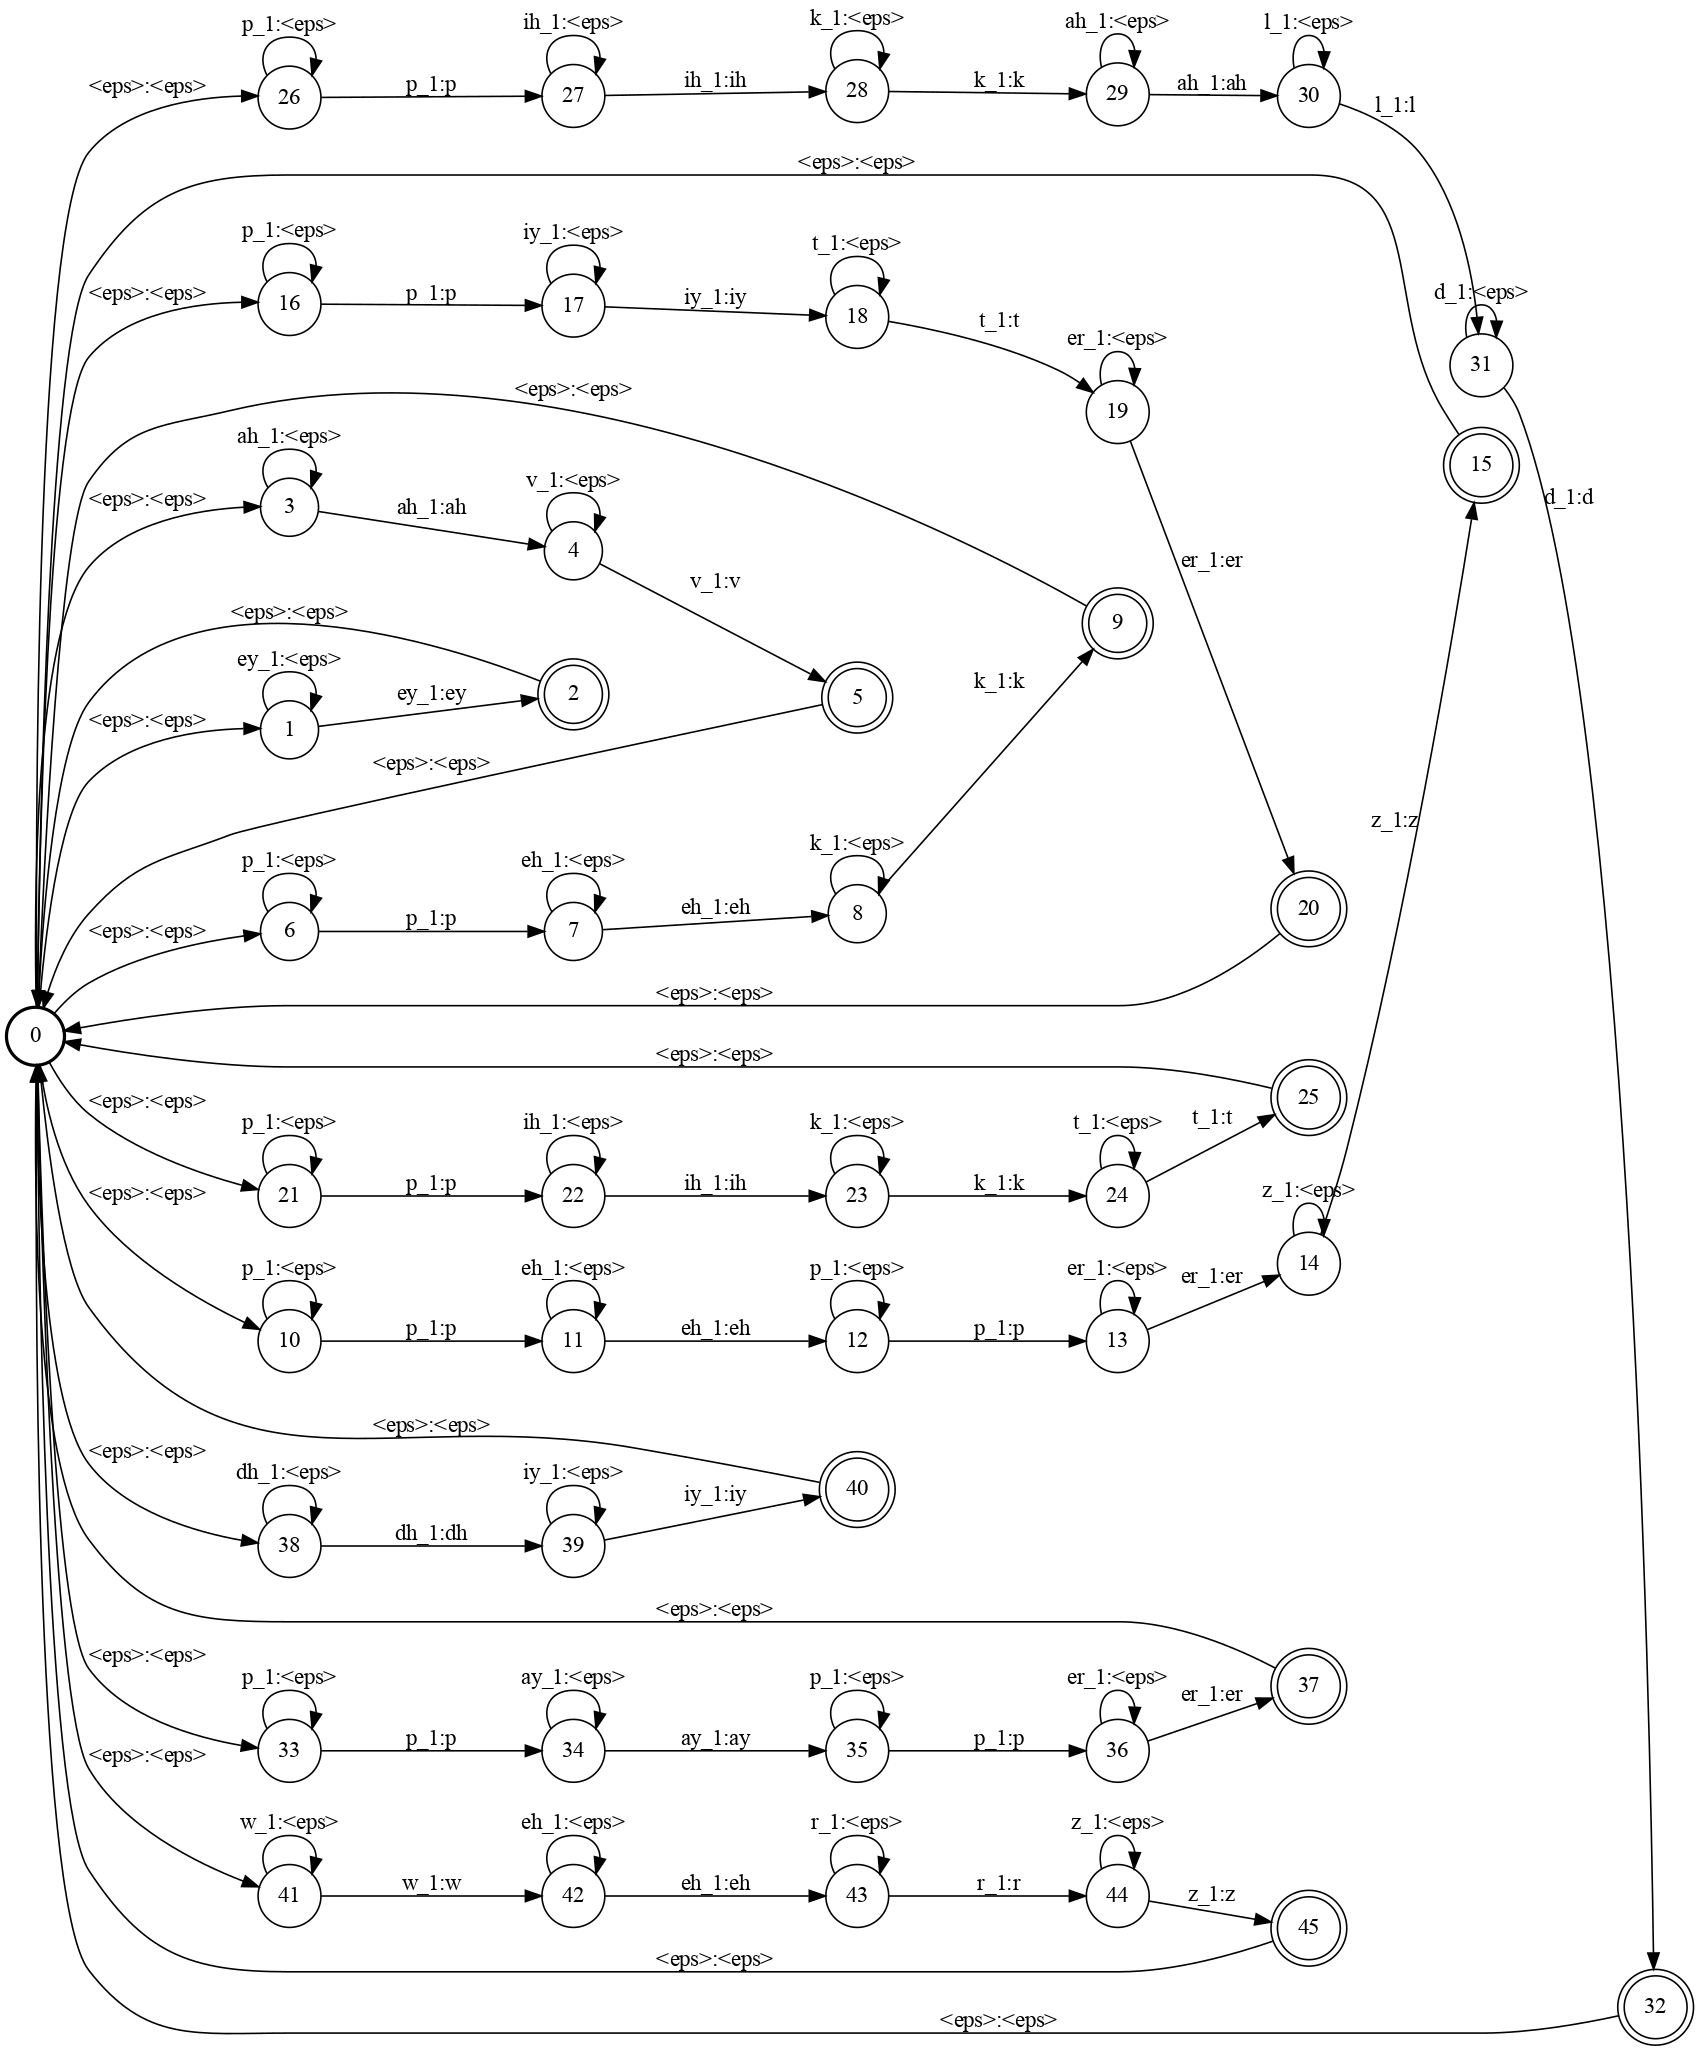

In [3]:
f = create_wfst(1)

display_fst(f)


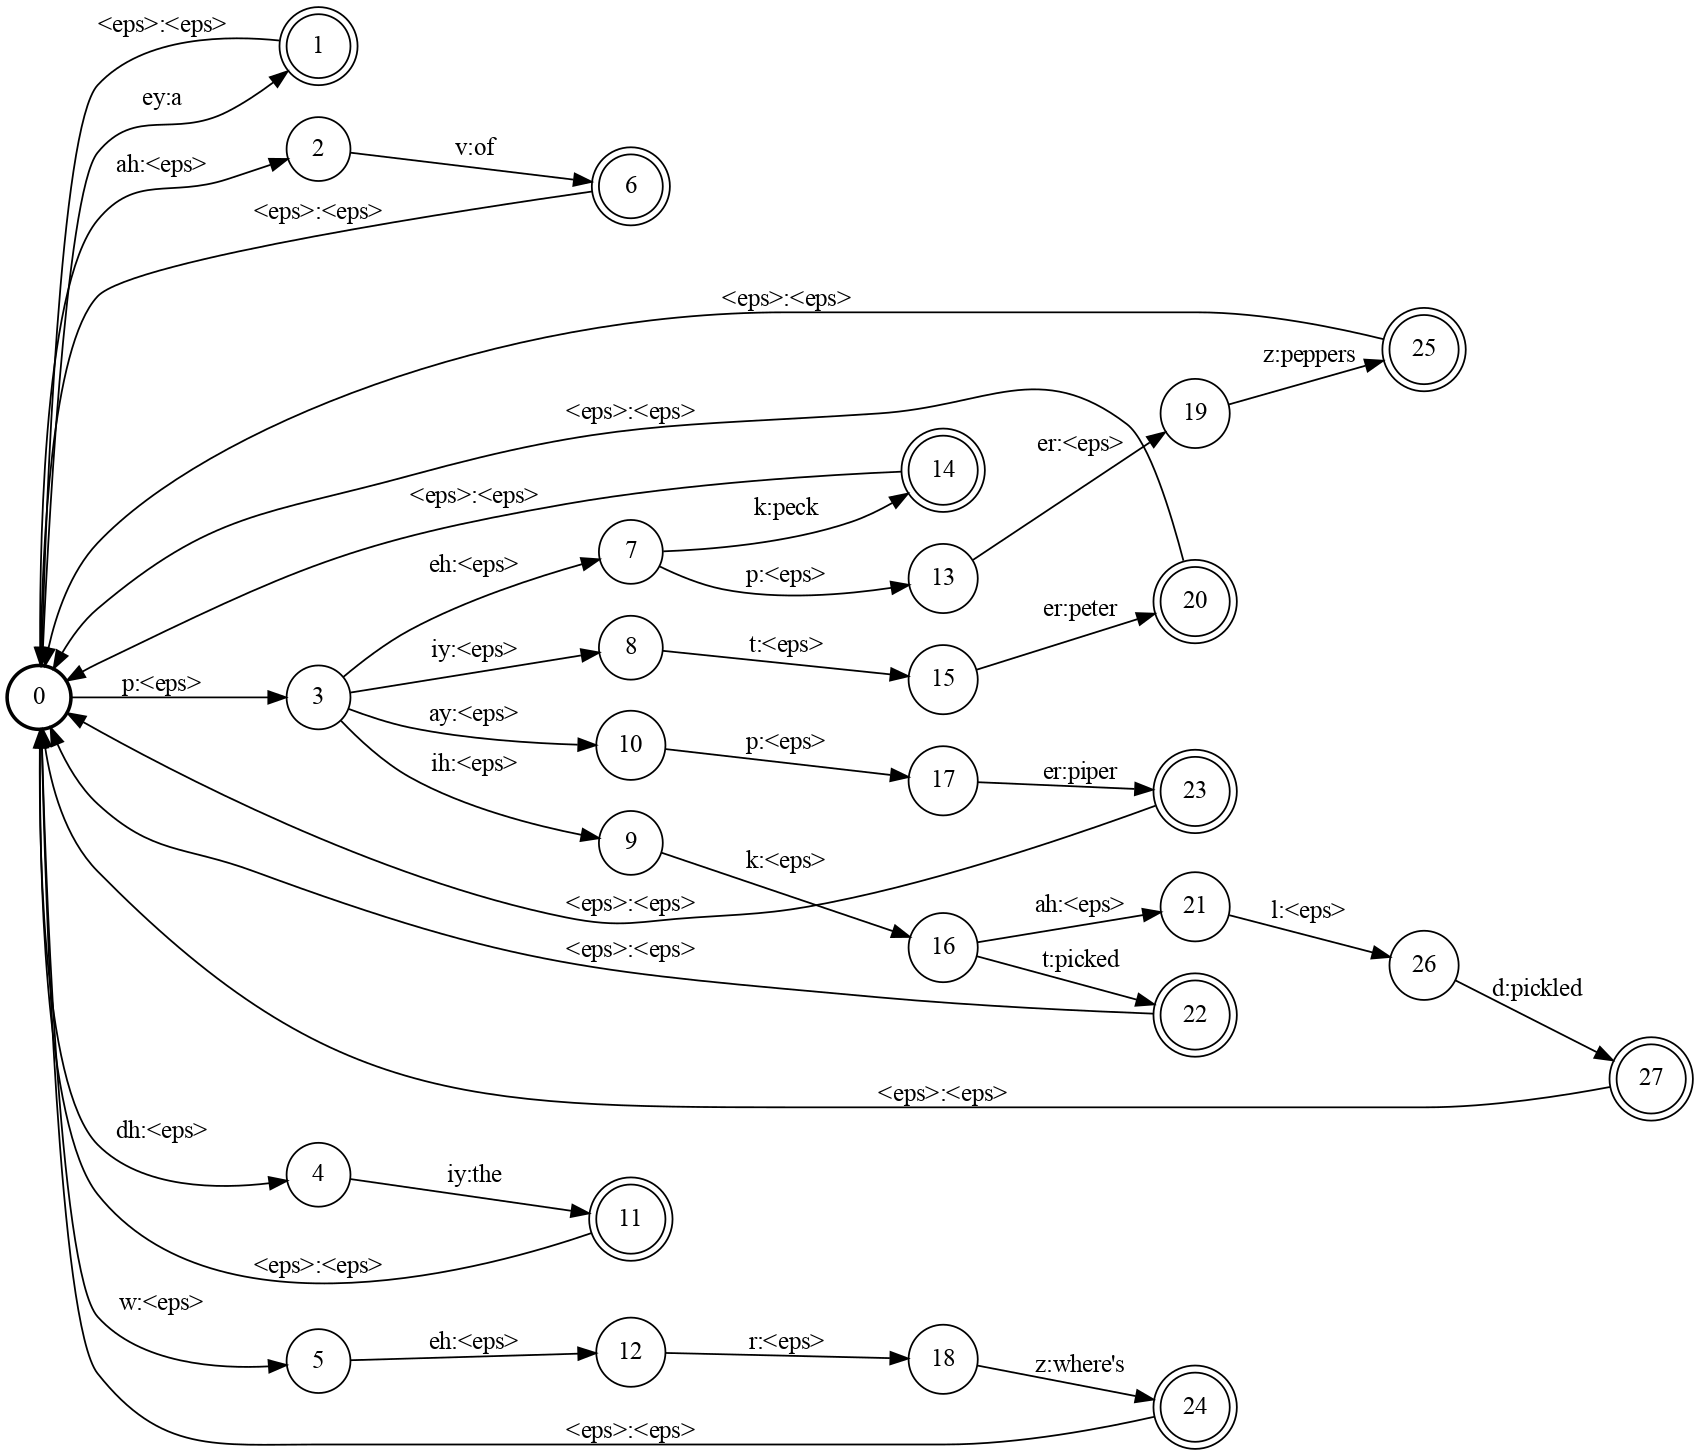

In [4]:
#lexicon transducer
import openfst_python as fst


lex = parse_lexicon('lexicon.txt')
word_table, phone_table, state_table = generate_symbol_tables(lex)  # we won't use state_table in this lab

def generate_L_wfst(lex):
    """ Express the lexicon in WFST form
    
    Args:
        lexicon (dict): lexicon to use, created from the parse_lexicon() function
    
    Returns:
        the constructed lexicon WFST
    
    """
    L = fst.Fst()
    
    # create a single start state
    start_state = L.add_state()
    L.set_start(start_state)
    
    for (word, pron) in lex.items():
        
        current_state = start_state
        for (i,phone) in enumerate(pron):
            next_state = L.add_state()
            
            if i == len(pron)-1:
                # add word output symbol on the final arc
                L.add_arc(current_state, fst.Arc(phone_table.find(phone), \
                                                 word_table.find(word), None, next_state))
            else:
                L.add_arc(current_state, fst.Arc(phone_table.find(phone),0, None, next_state))
            
            current_state = next_state
                          
        L.set_final(current_state)
        
    L.set_input_symbols(phone_table)
    L.set_output_symbols(word_table)  
    start_state = L.start()
    L.arcsort()
    for state in L.states():
        if float(L.final(state)) != math.inf:
            L.add_arc(state, fst.Arc(0, 0, None, start_state))
    
    return L

L = generate_L_wfst(lex)
Ldet = fst.determinize(L)
display_fst(Ldet)


In [5]:
def transduce_sequence_det(f, seq):
    """Return transduced sequence given input sequence and determinized FST
    
        Args:
            f (fst.Fst()): a determinized FST
            in_seq (list[str]): the sequence of strings to transduce
            
        Returns:
            out_seq (list[str]): the sequence of transduced symbols
            """
    
    seq_len = len(seq)
    eps = f.input_symbols().find('<eps>')
    curr_state = f.start()
    output = []
    
    for i in range(seq_len):
        
        found = False
        label = f.input_symbols().find(seq[i])
        
        while found ==False:
            for arc in f.arcs(curr_state):
                
                if arc.ilabel == label:
                    if arc.olabel != 0:

                        output_symbol = f.output_symbols().find(arc.olabel)
                        output.append(output_symbol)
                        

                    curr_state = arc.nextstate
                    found = True
                    break
                if arc.ilabel == 0:
                    curr_state = arc.nextstate
                    

    final_weight = float(f.final(curr_state))
    if final_weight != math.inf: # if this is a final state
        return output
    else:  
        print("Can't transduce the sequence with provided FST")
        
        


In [6]:
def read_transcription(wav_file):
    """
    Get the transcription corresponding to wav_file.
    """
    
    transcription_file = os.path.splitext(wav_file)[0] + '.txt'
    
    with open(transcription_file, 'r') as f:
        transcription = f.readline().strip()
    
    return transcription


f = create_wfst(3)



for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):    # replace path if using your own
                                                                           # audio files
    
    decoder = MyViterbiDecoder(f, wav_file)
    
    decoder.decode()
    (state_path, words) = decoder.backtrace()  
    print(words)# you'll need to modify the backtrace() from Lab 4
                                               # to return the words along the best path
    
    transcription = read_transcription(wav_file)
    
    word_count = len(transcription.split())
    words = words.split(" ")

    words= transduce_sequence_det(Ldet,words)
    words = " ".join(words)

    error_counts = wer.compute_alignment_errors(transcription, words)
    print(words)
    print(error_counts, word_count) 
    # you'll need to accumulate these to produce an overall Word Error Rate

    


p ih k ah l d dh iy p iy t er p ay p er p ih k t ey dh iy p eh k ah v p ih k ah l d p eh p er z w eh r z dh iy p eh k ah v p ih k ah l d p eh p er z p iy t er p ay p er p ih k t dh iy
pickled the peter piper picked a the peck of pickled peppers where's the peck of pickled peppers peter piper picked the
(0, 0, 4) 17
p ih k ah l d dh iy p ih k t dh iy p iy t er p ih k t dh iy ah v p eh k ah v p ih k ah l d p eh p er z dh iy
pickled the picked the peter picked the of peck of pickled peppers the
(1, 0, 6) 7
p ih k ah l d dh iy p eh k ah v p ih k ah l d p eh p er z p ih k t dh iy
pickled the peck of pickled peppers picked the
(1, 0, 2) 6
p ih k ah l d dh iy p iy t er p ay p er p iy t er p ay p er dh iy
pickled the peter piper peter piper the
(0, 0, 3) 4
p ih k ah l d dh iy w eh r z dh iy p ih k ah l d p ih k ah l d p eh p er z p ih k t dh iy
pickled the where's the pickled pickled peppers picked the
(3, 0, 2) 7
p iy t er p ay p er p ih k ah l d p eh p er z dh iy
peter piper pickled peppers 

p ih k t dh iy p ih k t p ay p er p ih k ah l d p eh k dh iy p ih k ah l d p eh p er z dh iy
picked the picked piper pickled peck the pickled peppers the
(4, 0, 2) 8
dh iy p eh k ah v dh iy p ih k ah l d ah v w eh r z p eh k p iy t er p ay p er dh iy
the peck of the pickled of where's peck peter piper the
(2, 0, 3) 8
p eh k dh iy p ay p er ah v p ih k t p iy t er dh iy p ih k ah l d p ih k t w eh r z dh iy
peck the piper of picked peter the pickled picked where's the
(1, 0, 5) 6
p eh k dh iy p eh k p ay p er p iy t er ah v p ih k ah l d p ih k t dh iy
peck the peck piper peter of pickled picked the
(0, 0, 4) 5
dh iy p eh k p eh p er z p ih k ah l d p iy t er p ay p er p ih k t dh iy
the peck peppers pickled peter piper picked the
(0, 0, 3) 5
dh iy p iy t er ah v p ay p er ey p ih k t ah v p ih k t ah v p ih k ah l d p eh p er z w eh r z p eh k ah v p ih k ah l d p eh p er z dh iy p ih k t ah v p ay p er p ih k t
the peter of piper a picked of picked of pickled peppers where's peck of p

dh iy w eh r z dh iy p ih k t ah v p eh p er z p iy t er p ay p er p ih k t ey p iy t er dh iy
the where's the picked of peppers peter piper picked a peter the
(1, 0, 4) 8
dh iy p eh k ah v p ih k ah l d p iy t er p ay p er ah v p ih k ah l d dh iy
the peck of pickled peter piper of pickled the
(0, 0, 2) 7
w eh r z p ay p er p iy t er p ih k t p eh p er z ah v p ay p er ah v dh iy p ih k t dh iy
where's piper peter picked peppers of piper of the picked the
(0, 0, 5) 6
dh iy p iy t er ah v p eh p er z p ih k t ah v p ay p er ah v dh iy p eh k dh iy
the peter of peppers picked of piper of the peck the
(1, 0, 3) 8
dh iy p ih k t ah v p ih k t p iy t er ah v p ay p er ah v p ih k t dh iy
the picked of picked peter of piper of picked the
(1, 0, 4) 6
p ih k t dh iy p ih k t dh iy p eh p er z p iy t er ah v p ih k ah l d dh iy
picked the picked the peppers peter of pickled the
(0, 0, 4) 5
dh iy p ay p er ah v p eh k p eh p er z p iy t er ah v p ih k t dh iy
the piper of peck peppers peter of 

p eh k dh iy p iy t er p ih k t p ih k t p ih k t dh iy
peck the peter picked picked picked the
(1, 0, 4) 3
p eh k p ih k t dh iy ah v p ay p er p ih k t ah v p eh k ah v p ih k ah l d p eh p er z
peck picked the of piper picked of peck of pickled peppers
(2, 0, 3) 8
p eh k dh iy p ih k t ey dh iy ah v p eh k ah v p ih k ah l d p eh p er z dh iy
peck the picked a the of peck of pickled peppers the
(0, 0, 5) 6
p ih k t dh iy w eh r z dh iy p ih k t ah v p ih k ah l d p eh p er z
picked the where's the picked of pickled peppers
(1, 0, 2) 6
p eh k dh iy p iy t er p ay p er p ih k t ah v p eh k dh iy w eh r z p eh k p iy t er p ih k t dh iy
peck the peter piper picked of peck the where's peck peter picked the
(1, 1, 4) 10
w eh r z dh iy p ih k t p ay p er p ih k t p ih k ah l d p eh p er z dh iy
where's the picked piper picked pickled peppers the
(1, 0, 3) 5
p ih k t ah v p ay p er p ih k t p ih k ah l d dh iy p ay p er w eh r z dh iy w eh r z dh iy p ih k t dh iy
picked of piper picked pi

dh iy p ih k ah l d p iy t er p ay p er p ih k t dh iy p eh k dh iy p eh p er z p ih k t dh iy
the pickled peter piper picked the peck the peppers picked the
(1, 0, 3) 8
p ih k t dh iy p iy t er ah v p ay p er p ih k t ah v p eh k ah v p ih k ah l d w eh r z dh iy
picked the peter of piper picked of peck of pickled where's the
(2, 0, 4) 8
dh iy w eh r z ah v ah v ah v p ih k t p eh p er z p ih k t ah v ah v p ih k t dh iy
the where's of of of picked peppers picked of of picked the
(5, 0, 3) 9
p eh k dh iy p iy t er p ih k t p ay p er w eh r z ah v p eh k dh iy
peck the peter picked piper where's of peck the
(1, 0, 3) 6
p eh k dh iy p ih k ah l d p ih k t ah v ah v ah v w eh r z ah v w eh r z p ih k t dh iy
peck the pickled picked of of of where's of where's picked the
(5, 0, 4) 8
dh iy p ay p er ah v p eh p er z w eh r z ah v p iy t er p ih k t p ih k t dh iy
the piper of peppers where's of peter picked picked the
(4, 0, 1) 9
dh iy p iy t er p ay p er ah v ey ah v p eh k ah v p ih k ah

p eh k dh iy ah v w eh r z w eh r z ah v p eh k p ih k ah l d ey dh iy ah v p ay p er p ih k t
peck the of where's where's of peck pickled a the of piper picked
(3, 1, 4) 10
dh iy ey p ih k t ey p ih k t p eh k ah v p ih k ah l d p eh p er z ey dh iy p eh k ah v p ih k ah l d p eh p er z p iy t er p ay p er p ih k t dh iy
the a picked a picked peck of pickled peppers a the peck of pickled peppers peter piper picked the
(3, 0, 2) 17
dh iy p ih k t ey dh iy p ih k t p ay p er p ih k t dh iy ey p ih k t ah v p eh k ah v p ih k ah l d p eh p er z w eh r z dh iy p eh k ah v p eh k p ih k ah l d p eh p er z p iy t er dh iy p ay p er ah v p ih k t dh iy dh iy
the picked a the picked piper picked the a picked of peck of pickled peppers where's the peck of peck pickled peppers peter the piper of picked the the
(1, 0, 12) 17
p ih k t dh iy p iy t er ah v p ay p er ah v dh iy dh iy ey dh iy ah v p eh k ah v p ih k ah l d p eh p er z dh iy w eh r z p ih k t p eh k ah v p ih k t ah v p eh p er z p 

dh iy dh iy ah v p iy t er ey dh iy ah v p ay p er dh iy ey p ih k ah l d w eh r z p eh k p ih k t w eh r z w eh r z p eh k ah v ah v p eh p er z p eh p er z p iy t er ey dh iy ah v p eh k w eh r z p ih k t dh iy
the the of peter a the of piper the a pickled where's peck picked where's where's peck of of peppers peppers peter a the of peck where's picked the
(8, 0, 12) 17
ah v ey w eh r z dh iy dh iy ah v p eh k ah v p ih k ah l d ah v w eh r z p ay p er dh iy dh iy
of a where's the the of peck of pickled of where's piper the the
(1, 0, 9) 5
p ih k t w eh r z p iy t er dh iy dh iy ey dh iy
picked where's peter the the a the
(1, 0, 4) 3
p ih k t dh iy dh iy ey dh iy p ih k ah l d p ih k t dh iy p ih k t w eh r z p ay p er dh iy
picked the the a the pickled picked the picked where's piper the
(1, 1, 9) 4
dh iy w eh r z w eh r z ah v p eh k ah v dh iy p eh p er z p ih k t ah v dh iy
the where's where's of peck of the peppers picked of the
(4, 0, 5) 6
p eh k dh iy ah v p iy t er p iy t er 